# <center> Netflix Stock Price Forecasting
---
---

**About Dataset**

The Dataset contains data for 5 years ie. from 5th Feb 2018 to 5th Feb 2022

The art of forecasting stock prices has been a difficult task for many of the researchers and analysts. In fact, investors are highly interested in the research area of stock price prediction. For a good and successful investment, many investors are keen on knowing the future situation of the stock market. Good and effective prediction systems for the stock market help traders, investors, and analyst by providing supportive information like the future direction of the stock market.

## Project Idea
The idea of this project is that we predict the closing price using the Arima model, with exogenous variables, the moving average for the last 2 periods and the open stock price. Maybe this can help for daily trading.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [2]:
#read data
df = pd.read_csv('NFLX.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [4]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1004,2022-01-31,401.970001,427.700012,398.200012,427.140015,427.140015,20047500
1005,2022-02-01,432.959991,458.480011,425.540009,457.130005,457.130005,22542300
1006,2022-02-02,448.250000,451.980011,426.480011,429.480011,429.480011,14346000
1007,2022-02-03,421.440002,429.260010,404.279999,405.600006,405.600006,9905200
1008,2022-02-04,407.309998,412.769989,396.640015,410.170013,410.170013,7782400


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1009 non-null   object 
 1   Open       1009 non-null   float64
 2   High       1009 non-null   float64
 3   Low        1009 non-null   float64
 4   Close      1009 non-null   float64
 5   Adj Close  1009 non-null   float64
 6   Volume     1009 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.3+ KB


In [6]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
#set the Date column to datetime 
df['Date'] = pd.to_datetime(df['Date'])

In [8]:
#set Date as data index
df.set_index('Date', inplace=True)

In [9]:
#Day name for each index
df.index.strftime('%A').unique()

Index(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], dtype='object', name='Date')

In [10]:
#set frequency to Business day frequency 'B'
df = df.asfreq('B')

In [11]:
#fill the null value with before value
data = df.fillna(method  = "bfill")

In [12]:
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Data Visualization

Text(0.5, 1.0, 'Open and AdClose Prices')

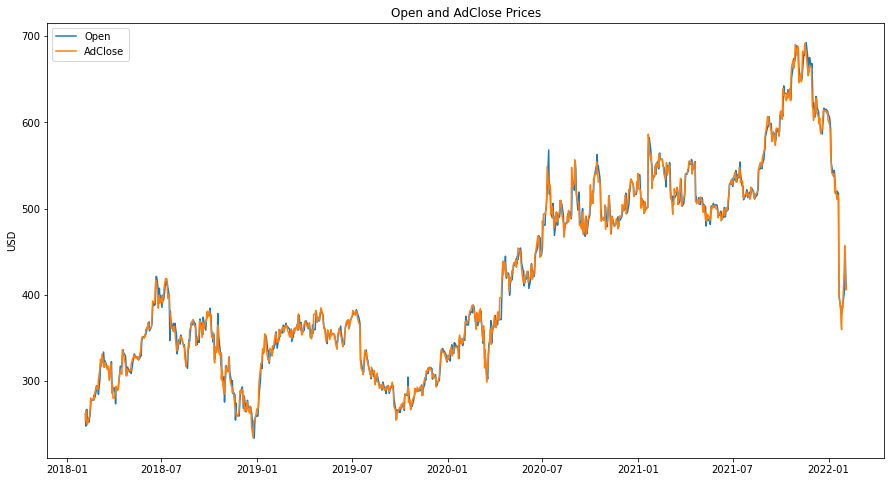

In [13]:
#Plot the Open and Adj Close data
plt.figure(figsize = (15,8))
plt.plot(data['Open'])
plt.plot(data['Adj Close'])
plt.ylabel('USD')
plt.legend(['Open','AdClose'])
plt.title('Open and AdClose Prices')

Text(0.5, 1.0, 'High and Low Prices of Stock')

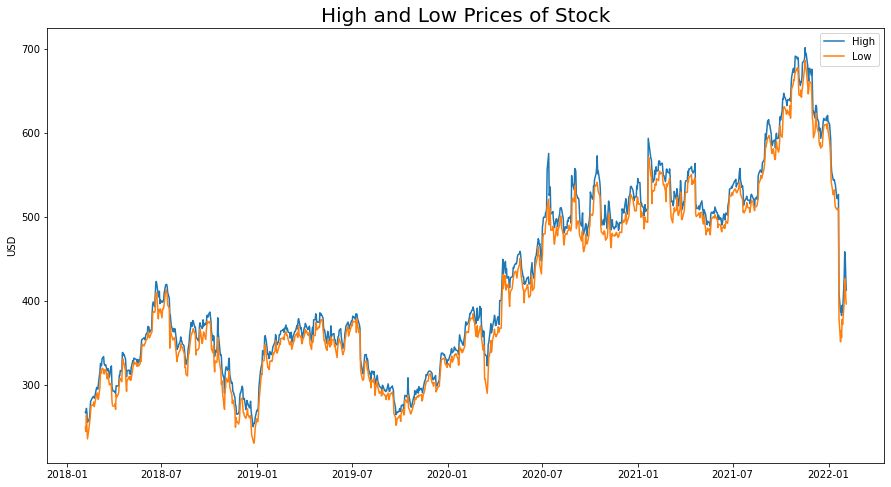

In [14]:
#plot the High and Low data
plt.figure(figsize = (15,8))
plt.plot(data['High'])
plt.plot(data['Low'])
plt.ylabel('USD')
plt.legend(['High','Low'])
plt.title('High and Low Prices of Stock', fontsize =20)

## Moving Average

- Note: This forecasting process for Close data only

In [15]:
#moving average for Close
data['MA2'] = data['Close'].shift(1).rolling(window=2).mean()

In [16]:
data.head(10)

,Open,High,Low,Close,Adj Close,Volume,MA2
Date,,,,,,,
2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100.0,NaN
2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800.0,NaN
2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500.0,259.989998
2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700.0,265.140000
2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900.0,257.330002
2018-02-12,252.139999,259.149994,249.000000,257.950012,257.950012,8534900.0,249.785004
2018-02-13,257.290009,261.410004,254.699997,258.269989,258.269989,6855200.0,253.710007
2018-02-14,260.470001,269.880005,260.329987,266.000000,266.000000,10972000.0,258.110001
2018-02-15,270.029999,280.500000,267.630005,280.269989,280.269989,10759700.0,262.134995


In [17]:
#drop the Null value
data.dropna(inplace=True)

In [18]:
#Correlation the data
data.corr()

,Open,High,Low,Close,Adj Close,Volume,MA2
Open,1.000000,0.998579,0.998518,0.996806,0.996806,-0.416816,0.996857
High,0.998579,1.000000,0.998205,0.998574,0.998574,-0.401674,0.995851
Low,0.998518,0.998205,1.000000,0.998540,0.998540,-0.433040,0.995209
Close,0.996806,0.998574,0.998540,1.000000,1.000000,-0.414226,0.994006
Adj Close,0.996806,0.998574,0.998540,1.000000,1.000000,-0.414226,0.994006
Volume,-0.416816,-0.401674,-0.433040,-0.414226,-0.414226,1.000000,-0.404327
MA2,0.996857,0.995851,0.995209,0.994006,0.994006,-0.404327,1.000000


## Run an ETS Decomposition

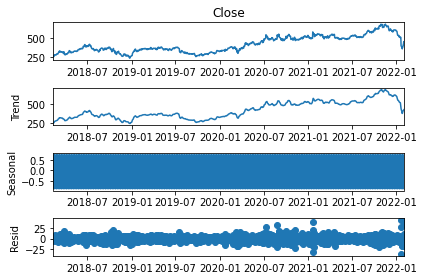

In [19]:
#Plot ETS Decomposition for Close data
results_close = seasonal_decompose(data['Close'], model='additive')
results_close.plot();

<AxesSubplot:xlabel='Date'>

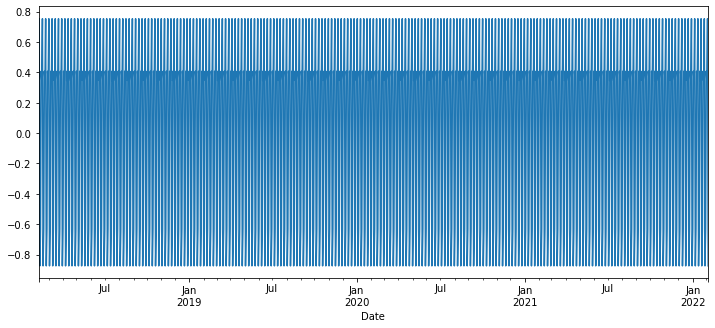

In [20]:
#Seasonal plot
results_close.seasonal.plot(figsize=(12,5))

- The seasonality plot is too dense, probably the data doesn't have specific seasonal terms

## Test for stationarity, perform any necessary transformations

In [21]:
#ADfuller test function
def adf_test(series,title=''):
    
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [22]:
#Fuller stasionary test for Close
adf_test(data['Close'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -1.764355
p-value                    0.398296
# lags used               14.000000
# observations          1028.000000
critical value (1%)       -3.436727
critical value (5%)       -2.864356
critical value (10%)      -2.568269
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [23]:
#Differencing petrol and diesel data
df_transform = data['Close'].diff()

In [24]:
#Fuller test for differencing Close
adf_test(df_transform)

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.942564e+00
p-value                 3.284076e-12
# lags used             1.300000e+01
# observations          1.028000e+03
critical value (1%)    -3.436727e+00
critical value (5%)    -2.864356e+00
critical value (10%)   -2.568269e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


## ACF and PACF PLot

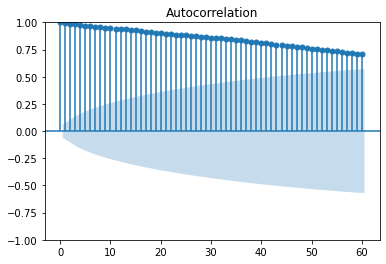

In [25]:
#ACF plot
plot_acf(data['Close'], lags=60);

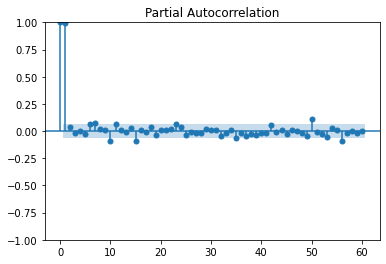

In [26]:
#PACF plot
plot_pacf(data['Close'],lags=60);

In [27]:
import math

- We do this forecasting with 20% for data test and 80% for data train

In [28]:
nobs = math.ceil(len(data)*0.2)
train = data.iloc[:-nobs]
test = data.iloc[-nobs:]

In [29]:
#Auto arima for Close data
auto_arima(train['Close'],seasonal=True, exogenous=train[['MA2', 'Open']], d=1, max_d=1).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  834
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2969.406
Date:                Fri, 06 May 2022   AIC                           5948.812
Time:                        01:05:12   BIC                           5972.437
Sample:                    02-07-2018   HQIC                          5957.870
                         - 04-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0144      0.012      1.239      0.215      -0.008       0.037
MA2            0.0852      0.030      2.876      0.004       0.027       0.143
Open           0.8673      0.022     39.148      0.000       0.824       0.911
ma.L1         -0.9689      0.018    -54.616      0.000      -1.004      -0.934
sigma2        72.8355      2.249     32.380      0.000      68.427      77.244
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               342.19
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- We can see the auto arima suggest ARIMA (0,1,1), but we need to compare AIC value and parameter significance test with other potential model such as ARIMA (1,1,0), ARIMA (1,1,1) and ARIMA (2,1,1) so we can get the best model to forecast the data.

.

### ARIMA(0,1,1)

In [30]:
model_011 = sm.tsa.arima.ARIMA(train['Close'], order=(0,1,1), exog= train[['MA2','Open']])
fitmodel_011 = model_011.fit()
fitmodel_011.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  834
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2970.425
Date:                Fri, 06 May 2022   AIC                           5948.851
Time:                        01:05:13   BIC                           5967.751
Sample:                    02-07-2018   HQIC                          5956.098
                         - 04-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
MA2            0.0866      0.030      2.922      0.003       0.029       0.145
Open           0.8665      0.022     39.115      0.000       0.823       0.910
ma.L1         -0.9655      0.019    -50.763      0.000      -1.003      -0.928
sigma2        73.0220      2.239     32.612      0.000      68.633      77.411
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):               341.63
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               1.69   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMA(1,1,0)

In [31]:
model_110 = sm.tsa.arima.ARIMA(train['Close'], order=(1,1,0), exog= train[['MA2','Open']])
fitmodel_110 = model_110.fit()
fitmodel_110.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  834
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -3009.863
Date:                Fri, 06 May 2022   AIC                           6027.725
Time:                        01:05:13   BIC                           6046.625
Sample:                    02-07-2018   HQIC                          6034.972
                         - 04-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
MA2           -0.3138      0.037     -8.561      0.000      -0.386      -0.242
Open           0.6535      0.022     30.273      0.000       0.611       0.696
ar.L1         -0.4685      0.029    -16.350      0.000      -0.525      -0.412
sigma2        80.5105      2.469     32.613      0.000      75.672      85.349
===================================================================================
Ljung-Box (L1) (Q):                   1.38   Jarque-Bera (JB):               386.36
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               1.70   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMA(1,1,1)

In [32]:
model_111 = sm.tsa.arima.ARIMA(train['Close'], order=(1,1,1), exog= train[['MA2','Open']])
fitmodel_111 = model_111.fit()
fitmodel_111.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  834
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2970.300
Date:                Fri, 06 May 2022   AIC                           5950.599
Time:                        01:05:14   BIC                           5974.225
Sample:                    02-07-2018   HQIC                          5959.658
                         - 04-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
MA2            0.0753      0.031      2.419      0.016       0.014       0.136
Open           0.8760      0.024     37.246      0.000       0.830       0.922
ar.L1         -0.0203      0.033     -0.617      0.538      -0.085       0.044
ma.L1         -0.9629      0.020    -48.881      0.000      -1.001      -0.924
sigma2        73.0034      2.247     32.484      0.000      68.599      77.408
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               338.60
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMA(2,1,1)

In [33]:
model_211 = sm.tsa.arima.ARIMA(train['Close'], order=(2,1,1), exog= train[['MA2','Open']])
fitmodel_211 = model_110.fit()
fitmodel_211.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  834
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -3009.863
Date:                Fri, 06 May 2022   AIC                           6027.725
Time:                        01:05:15   BIC                           6046.625
Sample:                    02-07-2018   HQIC                          6034.972
                         - 04-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
MA2           -0.3138      0.037     -8.561      0.000      -0.386      -0.242
Open           0.6535      0.022     30.273      0.000       0.611       0.696
ar.L1         -0.4685      0.029    -16.350      0.000      -0.525      -0.412
sigma2        80.5105      2.469     32.613      0.000      75.672      85.349
===================================================================================
Ljung-Box (L1) (Q):                   1.38   Jarque-Bera (JB):               386.36
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               1.70   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Statistical Test

### Significance Test

$H_0$ : Model parameters are not significant

$H_1$ : Model parameters are significant

Reject $H_0$ if *P-value* < 0.05

The ARIMA(1,1,1), and ARIMA(2,1,1) parameters has P-value  > 0.05, we failed to reject he $H_0$. This parameter is not significant.

The ARIMA(0,1,1) and ARIMA(1,1,0) parameters are significant, all parameters have P-values < 0.05. ARIMA(0,1,1) AIC  is lower than ARIMA(1,1,0) AIC. So for these two model ARIMA(0,1,1) is better.

### Ljungbox Test

We need to check residual model has white noise residual and has normal distributed condition.


In [34]:
#Ljung Box check
acorr_ljungbox(fitmodel_011.resid, lags=1, return_df=True)

,lb_stat,lb_pvalue
1,0.339044,0.560382


**Ljung-Box Test**:

$H_0$ : The residuals are independently distributed (white noise condition)

$H_1$ : The residuals are not independently distributed

Reject  $H_0$  if P-value < 0.05

Ljung Box test has P-value > 0.05, we failed to reject he $H_0$ which mean The residual ARIMA(0,1,1) has white noise condition.

### Normality Test for Residual Model

In [35]:
auto_011 = auto_arima(y=train[['Close']],seasonal=False, 
                      start_p=0, start_q=1, d=1, max_d=1, max_p=0, max_q=1,exogenous=train[['MA2', 'Open']])
auto_011.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  834
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2969.406
Date:                Fri, 06 May 2022   AIC                           5948.812
Time:                        01:05:17   BIC                           5972.437
Sample:                    02-07-2018   HQIC                          5957.870
                         - 04-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0144      0.012      1.239      0.215      -0.008       0.037
MA2            0.0852      0.030      2.876      0.004       0.027       0.143
Open           0.8673      0.022     39.148      0.000       0.824       0.911
ma.L1         -0.9689      0.018    -54.616      0.000      -1.004      -0.934
sigma2        72.8355      2.249     32.380      0.000      68.427      77.244
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               342.19
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

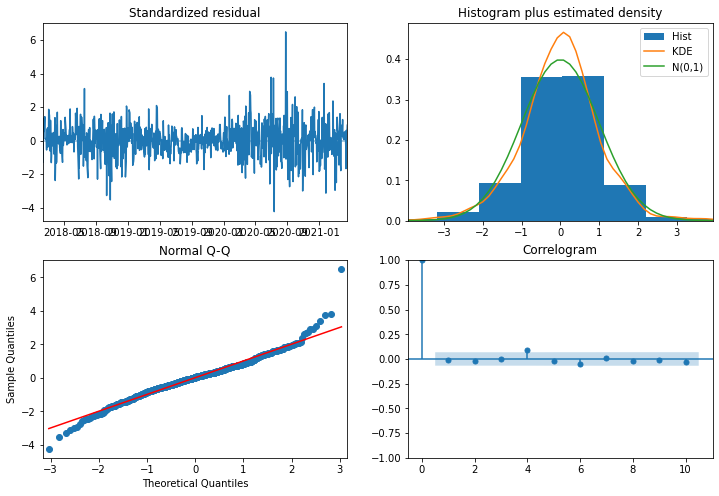

In [36]:
auto_011.plot_diagnostics(figsize=(12,8));

- Standardized residual plot shows the residual fluctuate around a mean of zero and have a uniform variance.
- The density plot suggest normal distribution with mean zero.
- Normal Q-Q plot shows the observations lie approximately on a straight line.
- The Correlogram (ACF plot) shows the residual errors are not autocorrelated.

From these conditions the model has a residual which is normally distributed. 

## Predict and Evaluate the Model

In [37]:
start = len(train)
end = start+len(test)-1

#Predict the train dataset
close_predict = fitmodel_011.predict(start=start, end=end, exog=test[['MA2', 'Open']]).rename('ARIMA (0,1,1) Predictions')
close_predict

2021-04-20    553.220426
2021-04-21    513.128146
2021-04-22    516.198299
2021-04-23    510.263194
2021-04-26    508.168404
                 ...    
2022-01-31    406.827057
2022-02-01    435.432321
2022-02-02    451.833993
2022-02-03    428.704140
2022-02-04    414.227825
Freq: B, Name: ARIMA (0,1,1) Predictions, Length: 209, dtype: float64

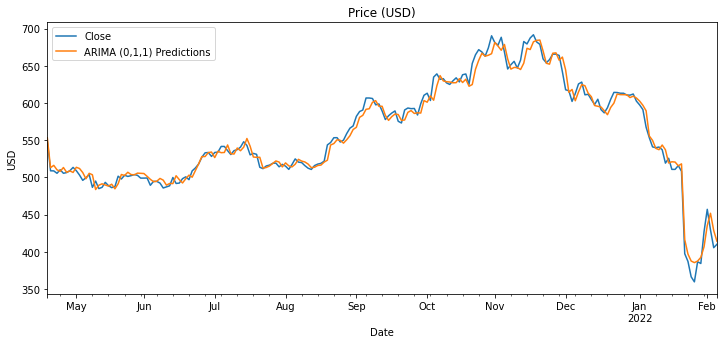

In [38]:
#plot the predction and the test dataset
ax = test['Close'].plot(figsize=(12,5), legend=True, title='Price (USD)')
ax.autoscale(axis='x', tight=True)
ax.set(ylabel='USD')
close_predict.plot(legend=True);

### Evaluate the Model

In [39]:
def eval_model(y_test, predict):
    mse = mean_squared_error(y_test, predict)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predict)
    mape = mean_absolute_percentage_error(y_test, predict)

    print(f'Mean Square Error ARIMA \t: {mse:5.6}')
    print(f'Root Mean Square Error ARIMA  \t: {rmse:5.6}')
    print(f'Mean Absolute Error ARIMA \t: {mae:5.6}')
    print(f'MAPE ARIMA \t\t\t: {mape:5.6}')

In [40]:
eval_model(test['Close'], close_predict)

Mean Square Error ARIMA 	: 88.4791
Root Mean Square Error ARIMA  	: 9.40633
Mean Absolute Error ARIMA 	: 7.02781
MAPE ARIMA 			: 0.0128515
